In [10]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import xarray as xr
import itertools

Заранее определяем параметры графиков.

In [76]:
mpl.rcParams['figure.figsize'] = (20,16)
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['figure.titlesize'] = 22
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['figure.autolayout'] = False

Мы решаем систему

\begin{gather}
\dot{x} = x\big(1 - 0.5x - \frac2{7\alpha^2}y\big)\\
\dot{y} = y\big(2\alpha - 3.5\alpha^2x - 0.5y\big)\\
\dot{\alpha} = \varepsilon\big(2 - 7\alpha x\big)
\end{gather}




Для общности введём списки различных значений параметров и будем решать задачу для всех возможных комбинаций.

По условию начальное значения $\alpha$ равно 0, но т.к. делить на 0 нельзя, в качестве н.у. будем использовать 0.01.

In [133]:
T = 50 # конечный момент времени
eps_list = pd.Series([1e-2], name = 'eps') # значения эпсилон
tau_list = pd.Series([0.01,0.11,0.15], name = 'tau') # значения тау - шага по сетке по времени
x0_list = pd.Series([1.5], name = 'x0') # значения начальных условий для x
y0_list = pd.Series([7.5], name = 'y0') # для y
a0_list = pd.Series([1], name = 'a0') # для alpha

Создадим функцию, вычисляющую эволюцию системы. В данном случае используется явный метод РК 1-го порядка.

In [134]:
def calc_evolution(x0_list = x0_list, y0_list = y0_list, a0_list = a0_list, eps_list = eps_list, T = T,\
                   tau_list = tau_list):
    '''
    Input:
    tau_list, x0_list, y0_list, a0_list, eps_list : списки значений шага tau, начальных условий x0, y0,
        a0 и параметра epsilon
    T : конечный момент времени

    Output:
    evolution_table : pd.DataFrame - таблица с историей эволюции для каждой комбинации параметров
    '''
    features_list = ['tau','x0','y0','a0','eps','t','x','y','a'] # названия столбцов в итоговой таблице
    evolution_table = pd.DataFrame(columns=features_list) # таблица, в которую будем записывать данные
    
    for tau, x0, y0, a0, eps in itertools.product(tau_list, x0_list, y0_list, a0_list, eps_list):
        t = 0
        x = x0; y = y0; a = a0
        row_to_append = pd.Series([tau, x0, y0, a0, eps, t, x, y, a],index=features_list)
        evolution_table = evolution_table.append(row_to_append,ignore_index=True)
        for i in range(int(T/tau)):
            # Здесь начинается метод РК 1-го порядка. Так как альфа может быть 0, то перед его возведением в -1
            # степень ограничим альфу снизу до 0.1 по модулю.
            t+=tau
            x_new = x + tau*x*(1-0.5*x-2*y/(7*(max(abs(a),1e-1)*np.sign(a))**2))
            y_new = y + tau*y*(2*a-3.5*x*a**2-0.5*y)
            a_new = a + tau*eps*(2-7*a*x)
            x = x_new; y = y_new; a = a_new
            row_to_append[:] = tau, x0, y0, a0, eps, t, x, y, a
            evolution_table = evolution_table.append(row_to_append,ignore_index=True)
            if max(abs(x),abs(y),abs(a)) > 1e5: # если переполнение - то останавливаемся
                break
                print('Overflow')

    evolution_table = evolution_table.set_index(['tau','x0','y0','a0','eps'])
    return evolution_table

Для построения графиков создадим отдельную функцию.

In [136]:
def plot_it(evolution_table,tau_list, x0_list, y0_list, a0_list, eps_list, figsize = (20,16)):
    
    fig, axes = plt.subplots(nrows=2, ncols=2)
    ax0, ax1, ax2, ax3 = axes.flatten()

    for tau, x0, y0, a0, eps in itertools.product(tau_list, x0_list, y0_list, a0_list, eps_list):
        label = ''
        title = ''
        for param, param_list in zip([tau, x0, y0, a0, eps],[tau_list,x0_list,y0_list,a0_list,eps_list]):
            if len(param_list) > 1: label = label + param_list.name + ' =' + str(param) + ', '
            else: title = title + param_list.name + ' =' + str(param) + ', '
        ax0.plot(evolution_table.loc[tau, x0, y0, a0, eps]['t'],evolution_table.loc[tau, x0, y0, a0, eps]['x'],label=label)
        ax0.set_xlabel('t')
        ax0.set_ylabel('x')
        ax1.plot(evolution_table.loc[tau, x0, y0, a0, eps]['t'],evolution_table.loc[tau, x0, y0, a0, eps]['y'],label=label)
        ax1.set_xlabel('t')
        ax1.set_ylabel('y')
        ax2.plot(evolution_table.loc[tau, x0, y0, a0, eps]['t'],evolution_table.loc[tau, x0, y0, a0, eps]['a'],label=label)
        ax2.set_xlabel('t')
        ax2.set_ylabel('a')
        ax3.plot(evolution_table.loc[tau, x0, y0, a0, eps]['x'],evolution_table.loc[tau, x0, y0, a0, eps]['y'],label=label)
        ax3.set_xlabel('x')
        ax3.set_ylabel('y')

    fig.suptitle(title)
        
    for ax in axes.flatten():
        ax.legend()

Вычисляем эволюцию системы.

In [135]:
evolution_table = calc_evolution(x0_list = x0_list, y0_list = y0_list, a0_list = a0_list,\
    eps_list = eps_list, T = T, tau_list = tau_list)

Видно, что при $\tau = 0.15$ схема начинает расходиться.

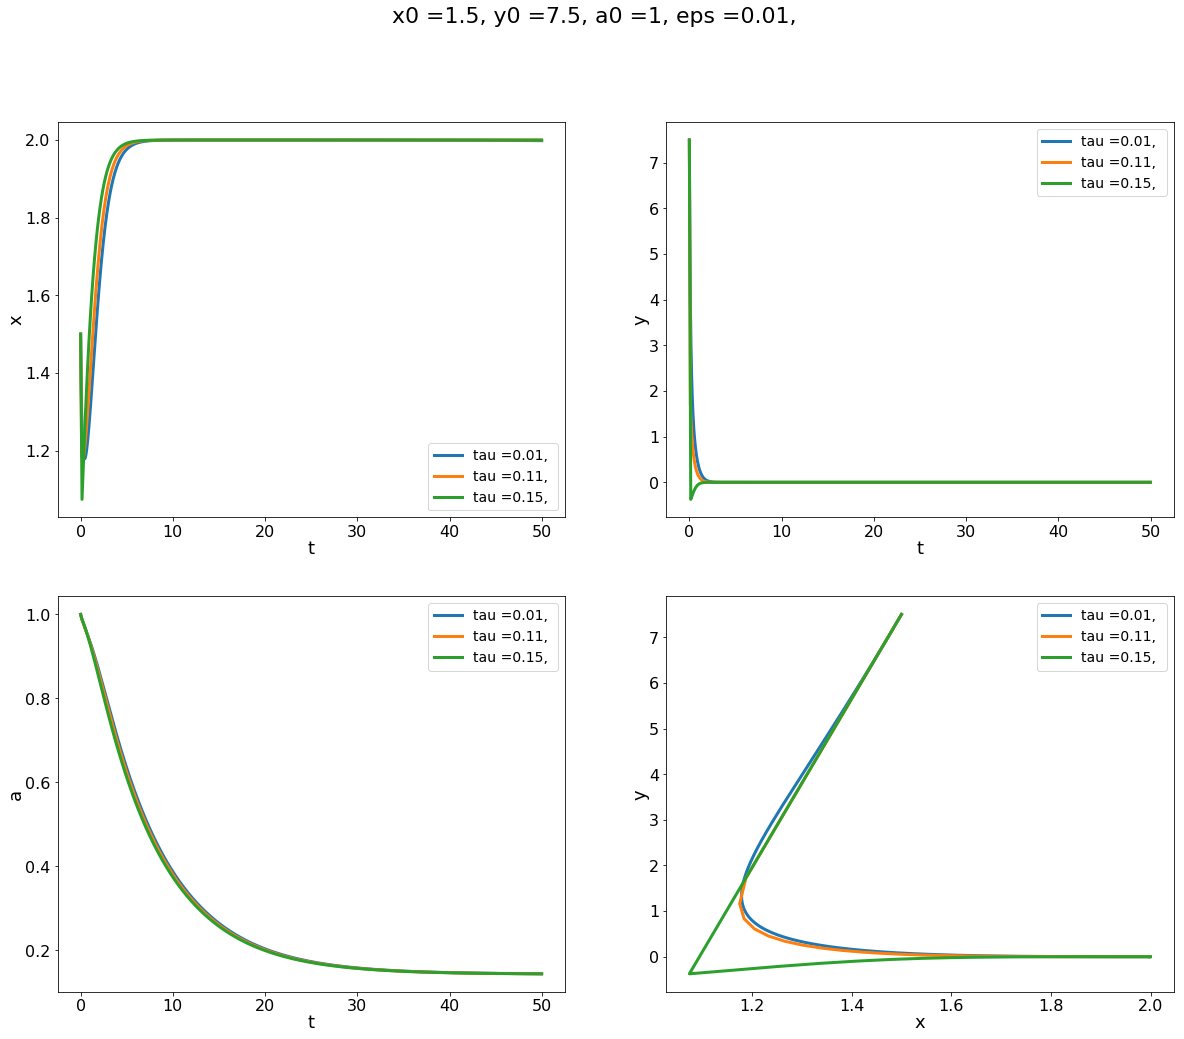

In [137]:
plot_it(evolution_table,tau_list, x0_list, y0_list, a0_list, eps_list, figsize = (20,16))

In [174]:
T = 2000 # конечный момент времени
eps_list = pd.Series([1e-2], name = 'eps') # значения эпсилон
tau_list = pd.Series([0.05], name = 'tau') # значения тау - шага по сетке по времени
x0_list = pd.Series([0.1,2], name = 'x0') # значения начальных условий для x
y0_list = pd.Series([1,10], name = 'y0') # для y
a0_list = pd.Series([0.8,1.25], name = 'a0') # для alpha

In [ ]:
evolution_table = calc_evolution(x0_list = x0_list, y0_list = y0_list, a0_list = a0_list,\
    eps_list = eps_list, T = T, tau_list = tau_list)

In [ ]:
plot_it(evolution_table,tau_list, x0_list, y0_list, a0_list, eps_list, figsize = (20,16))

# Второй случай

In [25]:
eps_list = pd.Series([1e-2], name = 'eps')
T = 4
tau_list = pd.Series([5e-4], name = 'tau')
x0_list = pd.Series([20], name = 'x0')
y0_list = pd.Series([20], name = 'y0')
a10_list = pd.Series([1.], name = 'a0')
a20_list = pd.Series([10.], name = 'a0')

In [26]:
def calc_evolution_2(x0_list = x0_list, y0_list = y0_list, a10_list = a10_list,\
                     a20_list = a20_list, eps_list = eps_list, T = T, tau_list = tau_list):
    features_list = ['tau','x0','y0','a10','a20','eps','t','x','y','a1','a2']
    evolution_table = pd.DataFrame(columns=features_list)
    
    for tau, x0, y0, a10, a20, eps in itertools.product(tau_list, x0_list, y0_list, a10_list, a20_list, eps_list):
        t = 0
        x = x0; y = y0; a1 = a10; a2 = a20
        row_to_append = pd.Series([tau, x0, y0, a10, a20, eps, t, x, y, a1, a2],index=features_list)
        evolution_table = evolution_table.append(row_to_append,ignore_index=True)
        for i in range(int(T/tau)):
            t+=tau
#             b1 = min(a1**(-2),100)
#             b2 = min(a2**(-2),100)
            b1 = a1**(-2)
            b2 = a2**(-2)
            x_new = x + tau*x*(2*a1-0.5*x-a1**2*b2*y)
            y_new = y + tau*y*(2*a2-0.5*y-a2**2*b1*x)
            a1_new = a1 + tau*eps*(2-2*a1*b2*y)
            a2_new = a2 + tau*eps*(2-2*a2*b1*x)
            x = x_new; y = y_new; a1 = a1_new; a2 = a2_new
            row_to_append[:] = tau, x0, y0, a10, a20, eps, t, x, y, a1, a2
            evolution_table = evolution_table.append(row_to_append,ignore_index=True)
            if max(abs(x),abs(y),abs(a1),abs(a2)) > 1e5:
                break
                print('Overflow')

    evolution_table = evolution_table.set_index(['tau','x0','y0','a10','a20','eps'])
    return evolution_table


In [27]:
def plot_it_2(evolution_table,tau_list, x0_list, y0_list, a10_list, a20_list, eps_list, figsize = (20,16)):
    mpl.rcParams['figure.figsize'] = figsize
    fig, axes = plt.subplots(nrows=3, ncols=2)
    ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

    for tau, x0, y0, a10, a20, eps in itertools.product(tau_list, x0_list, y0_list,\
                                                    a10_list, a20_list, eps_list):
        label = ''
        title = ''
        for param, param_list in zip([tau, x0, y0, a10, a20, eps],[tau_list,x0_list,y0_list,a10_list,a20_list,eps_list]):
            if len(param_list) > 1: label = label + param_list.name + ' =' + str(param) + ', '
            else: title = title + param_list.name + ' =' + str(param) + ', '
        ax0.plot(evolution_table.loc[tau, x0, y0, a10, a20, eps]['t'],evolution_table.loc[tau, x0, y0, a10, a20, eps]['x'],label=label)
        ax0.set_xlabel('t')
        ax0.set_ylabel('x')
        ax1.plot(evolution_table.loc[tau, x0, y0, a10, a20, eps]['t'],evolution_table.loc[tau, x0, y0, a10, a20, eps]['y'],label=label)
        ax1.set_xlabel('t')
        ax1.set_ylabel('y')
        ax2.plot(evolution_table.loc[tau, x0, y0, a10, a20, eps]['t'],evolution_table.loc[tau, x0, y0, a10, a20, eps]['a1'],label=label)
        ax2.set_xlabel('t')
        ax2.set_ylabel('a1')
        ax3.plot(evolution_table.loc[tau, x0, y0, a10, a20, eps]['t'],evolution_table.loc[tau, x0, y0, a10, a20, eps]['a2'],label=label)
        ax3.set_xlabel('t')
        ax3.set_ylabel('a2')
        ax4.plot(evolution_table.loc[tau, x0, y0, a10, a20, eps]['x'],evolution_table.loc[tau, x0, y0, a10, a20, eps]['y'],label=label)
        ax4.set_xlabel('x')
        ax4.set_ylabel('y')

    fig.suptitle(title)
        
    for ax in axes.flatten():
        ax.legend()

In [28]:
evolution_table = calc_evolution_2()

/home/asm/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


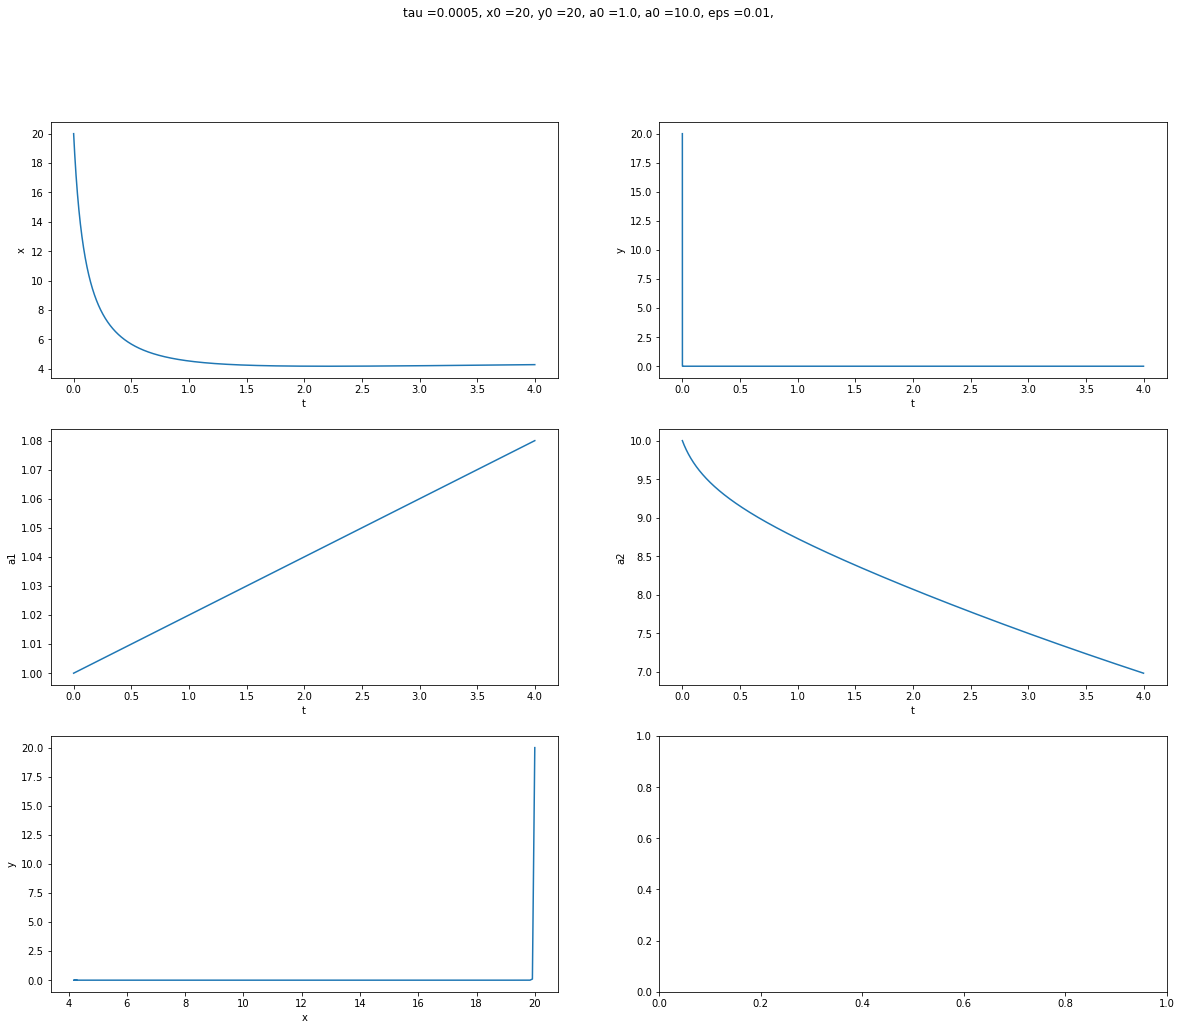

In [29]:
plot_it_2(evolution_table,tau_list, x0_list, y0_list, a10_list, a20_list, eps_list, figsize = (20,16))